This notebook aims to check whether the lightning NO2 is included in the TM5 NO2 profile (at least above the cloud pressure).

According to the ATBD, the TM5 model only assimilates the slant column densities.

![OFFL](./imgs/OFFL_processing.png)

> For OFFL the processing starts with the DOAS spectral fits and derivation of the slant columns (red box).
>
> These are stored in preliminary NO2 L2 files and read by the TM5-MP chemistry-transport model.
>
> The air-mass factors, averaging kernels and vertical columns are computed in a retrieval module which is part of TM5-MP, using the model fields co-located in space and time to the measurement time and footprint.
> 
> After the retrieval step the NO2 total slant columns are assimilated in TM5-MP.
> 
> The result of this step is a stratospheric column which is in good agreement with the TROPOMI data.

In [1]:
import numpy as np
import proplot as pplt
from satpy import Scene
from glob import glob
import xarray as xr

pplt.rc['cmap'] = 'viridis'
pplt.rc.update({'meta.width': 0.6, 'label.weight': 'bold', 'tick.labelweight': 'normal'})

## Define loading data functions

In [36]:
def load_tropomi(filename):
    """Load TROPOMI NO2 L2 products by satpy"""
    scn = Scene(filename, reader='tropomi_l2')
    vnames = ['cloud_radiance_fraction_nitrogendioxide_window', 'cloud_pressure_crb',
              'assembled_lat_bounds', 'assembled_lon_bounds',
              'longitude', 'latitude', 'qa_value',
              'tm5_constant_a', 'tm5_constant_b', 'surface_pressure',
              'averaging_kernel', 'air_mass_factor_troposphere', 'air_mass_factor_clear', 'air_mass_factor_cloudy',
              'oxygen_oxygen_dimer_slant_column_density',
              'nitrogendioxide_ghost_column', 'nitrogendioxide_tropospheric_column',
              'nitrogendioxide_slant_column_density', 'nitrogendioxide_stratospheric_column', 'air_mass_factor_stratosphere',
              'solar_zenith_angle', 'viewing_zenith_angle']

    if 'no2_vmr' in scn.available_dataset_names():
        vnames.append('no2_vmr')
        scn.load(vnames)
        scn['no2_vmr'] = scn['no2_vmr'].assign_coords({'longitude': scn['nitrogendioxide_tropospheric_column'].longitude})
    else:
        scn.load(vnames)

    scn['SCD_Strato'] = scn['nitrogendioxide_stratospheric_column'] * scn['air_mass_factor_stratosphere']
    scn['SCD_Trop'] = scn['nitrogendioxide_slant_column_density'] - scn['SCD_Strato']

    scn['SCD_Strato'] = scn['SCD_Strato'].rename('SCD_Strato')
    scn['SCD_Trop'] = scn['SCD_Trop'].rename('SCD_Trop')
    scn['SCD_Strato'].attrs['units'] = 'mol m-2'
    scn['SCD_Trop'].attrs['units'] = 'mol m-2'

    # calculate pressure levels
    a = scn['tm5_constant_a']
    b = scn['tm5_constant_b']
    psfc = scn['surface_pressure']

    low_p = (a[:, 0] + b[:, 0]*psfc)/1e2
    high_p = (a[:, 1] + b[:, 1]*psfc)/1e2

    scn['p'] = xr.concat([low_p, high_p.isel(layer=-1)], dim='layer')
    scn['p'] = scn['p'].rolling({'layer': 2}).mean()[1:, ...].load()
    scn['p'] = scn['p'].rename('tm5_pressure')
    scn['p'].attrs['units'] = 'hPa'

    # assign lon/lat coords
    scn['p'] = scn['p'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['solar_zenith_angle'] = scn['solar_zenith_angle'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['air_mass_factor_clear'] = scn['air_mass_factor_clear'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['air_mass_factor_cloudy'] = scn['air_mass_factor_cloudy'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['nitrogendioxide_slant_column_density'] = scn['nitrogendioxide_slant_column_density'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['viewing_zenith_angle'] = scn['viewing_zenith_angle'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['oxygen_oxygen_dimer_slant_column_density'] = scn['oxygen_oxygen_dimer_slant_column_density'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )

    return scn

In [3]:
def get_scn(f_pre, f_ltng, f_post):
    scn_ltng_pre = load_tropomi(f_pre)
    scn_ltng = load_tropomi(f_ltng)
    scn_ltng_post = load_tropomi(f_post)

    return scn_ltng_pre, scn_ltng, scn_ltng_post

In [4]:
def mask_scn(scn, lon_min, lon_max, lat_min, lat_max):
    """mask the Scene to the lightning NO2 region"""
    mask = (scn['longitude'] >= lon_min) & \
           (scn['longitude'] <= lon_max) & \
           (scn['latitude'] >= lat_min) & \
           (scn['latitude'] <=lat_max)

    return scn['SCD_Strato'].where(mask, drop=True), \
           scn['SCD_Trop'].where(mask, drop=True), \
           scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True), \
           scn['no2_vmr'].where(mask, drop=True) ,\
           scn['p'].where(mask, drop=True)

## Define plotting functions

In [5]:
def plot_no2(scn_list, lon_min, lon_max, lat_min, lat_max, vmax_strato=4e-4):
    fig, axs = pplt.subplots(nrows=3, ncols=3)

    for index,scn in enumerate(scn_list):
        scd_strato, scd_trop, vcd_trop, _, _ = mask_scn(scn, lon_min, lon_max, lat_min, lat_max)

        scd_strato.plot(
                    x='longitude', y='latitude', ax=axs[index*3],
                    cmap='Thermal', vmin=2.5e-4, vmax=vmax_strato, discrete=False,
                    )

        scd_trop.plot(
                    x='longitude', y='latitude', ax=axs[index*3+1],
                    cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-4.5e-5, vmax=4.5e-5, discrete=False,
                    )

        vcd_trop.plot(
                    x='longitude', y='latitude', ax=axs[index*3+2],
                    cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-3e-5, vmax=3e-5,  discrete=False,
                    )

        if index == 1:
            print(vcd_trop.max().load())

    axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
               xlabel='Longitude', ylabel='Latitude', title='',
               toplabels=['SCD_Strato', 'SCD_Trop', 'VCD_Trop'],
               leftlabels=['one day before',
                           'lightning day',
                           'one day after'],
               facecolor='Gray'
               )
    

In [6]:
def plot_cld(scn_list, lon_min, lon_max, lat_min, lat_max):
    """Plot the cloud variabls"""
    fig, axs = pplt.subplots(nrows=3, ncols=3)

    for index,scn in enumerate(scn_list):
        mask = (scn['longitude'] >= lon_min) & \
            (scn['longitude'] <= lon_max) & \
            (scn['latitude'] >= lat_min) & \
            (scn['latitude'] <=lat_max)

        scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True).plot(
                    x='longitude', y='latitude', ax=axs[index*3],
                    cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-3e-5, vmax=3e-5,  discrete=False,
                    )

        (scn['cloud_pressure_crb']/1e2).where(mask, drop=True).plot(
                    x='longitude', y='latitude', ax=axs[index*3+1],
                    cmap='Blues', vmin=100, vmax=1e3, discrete=False)

        scn['cloud_radiance_fraction_nitrogendioxide_window'].where(mask, drop=True).plot(
                    x='longitude', y='latitude', ax=axs[index*3+2],
                    cmap='Blues_r', vmin=0, vmax=1, discrete=False)

    axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
               xlabel='Longitude', ylabel='Latitude', title='',
               toplabels=['VCD_Trop', 'Cloud Pressure', 'Cloud Radiance Fraction'],
               leftlabels=['one day before',
                           'lightning day',
                           'one day after'],
               facecolor='Gray'
               )

In [7]:
def plot_no2_profile(scn_list, lon_min, lon_max, lat_min, lat_max):
    """Plot the mean TM5 NO2 profile over the selected convective region"""
    _, _, _, no2_pre, pressure_pre = mask_scn(scn_list[0], lon_min, lon_max, lat_min, lat_max)
    no2_pre = no2_pre.mean(['x', 'y'])
    pressure_pre = pressure_pre.mean(['x', 'y'])

    _, _, _, no2_ltng, pressure_ltng = mask_scn(scn_list[1], lon_min, lon_max, lat_min, lat_max)
    no2_ltng = no2_ltng.mean(['x', 'y'])
    pressure_ltng = pressure_ltng.mean(['x', 'y'])

    _, _, _, no2_post, pressure_post = mask_scn(scn_list[2], lon_min, lon_max, lat_min, lat_max)
    no2_post = no2_post.mean(['x', 'y'])
    pressure_post = pressure_post.mean(['x', 'y'])

    fig, axs = pplt.subplots()

    l_ltng = axs.plot(no2_ltng*1e12, pressure_ltng, label='lightning')
    l_noltng_before = axs.plot(no2_pre*1e12, pressure_pre, label='no lightning (one day before)')
    l_noltng_after = axs.plot(no2_post*1e12, pressure_post, label='no lightning (one day after)')


    axs.legend([l_noltng_before, l_ltng, l_noltng_after], loc='r', ncols=1)
    axs.format(xlabel='TM5 a priori NO2 (pptv)', ylabel='Pressure (hPa)', ylim=(1000, 100), xlim=(0, 300))

In [8]:
def plot_no2_plev(scn_list, lon_min, lon_max, lat_min, lat_max):
    # fig, axs = pplt.subplots(nrows=3, ncols=3)

    _, _, _, no2_pre, pressure_pre = mask_scn(scn_list[0], lon_min, lon_max, lat_min, lat_max)
    no2_pre = no2_pre.isel(layer=11)

    _, _, _, no2_ltng, pressure_ltng = mask_scn(scn_list[1], lon_min, lon_max, lat_min, lat_max)
    no2_ltng = no2_ltng.isel(layer=11)

    _, _, _, no2_post, pressure_post = mask_scn(scn_list[2], lon_min, lon_max, lat_min, lat_max)
    no2_post = no2_post.isel(layer=11)

    fig, axs = pplt.subplots(ncols=3)

    no2_pre.plot(ax=axs[0], x='longitude', y='latitude', vmin=0, vmax=5e-11, discrete=False)
    no2_ltng.plot(ax=axs[1], x='longitude', y='latitude', vmin=0, vmax=5e-11, discrete=False)
    no2_post.plot(ax=axs[2], x='longitude', y='latitude', vmin=0, vmax=5e-11, discrete=False)

    axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
               xlabel='Longitude', ylabel='Latitude',
               title=['', '', ''],
               suptitle='TM5 a priori NO2 profile at layer_11 (~350 hPa)',
               toplabels=['one day before',
                           'lightning day',
                           'one day after'],
               facecolor='Gray',
               )

## Case 1: 2019-08-09

In [9]:
f_pre = glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190809T21*.nc')
f_ltng = glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190810T21*.nc')
f_post = glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190811T21*.nc')

scn_ltng_pre, scn_ltng, scn_ltng_post = get_scn(f_pre, f_ltng, f_post)

Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/cloud_selection_flag
Can't load ancillary dataset /PRODUCT/tm5_constant_a
Can't load ancillary dataset /PRODUCT/tm5_constant_b
Can't load ancillary dataset /PRODUCT/tm5_tropopause_layer_index
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/air_mass_factor_total
Can't load ancillary dataset /PRODUCT/averaging_kernel
Can't load ancillary dataset /PRODUCT/tm5_tropopause_layer_index
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/cloud_select

<xarray.DataArray 'nitrogendioxide_tropospheric_column' ()>
array(4.8297334e-05, dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-08-10
    crs      object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs


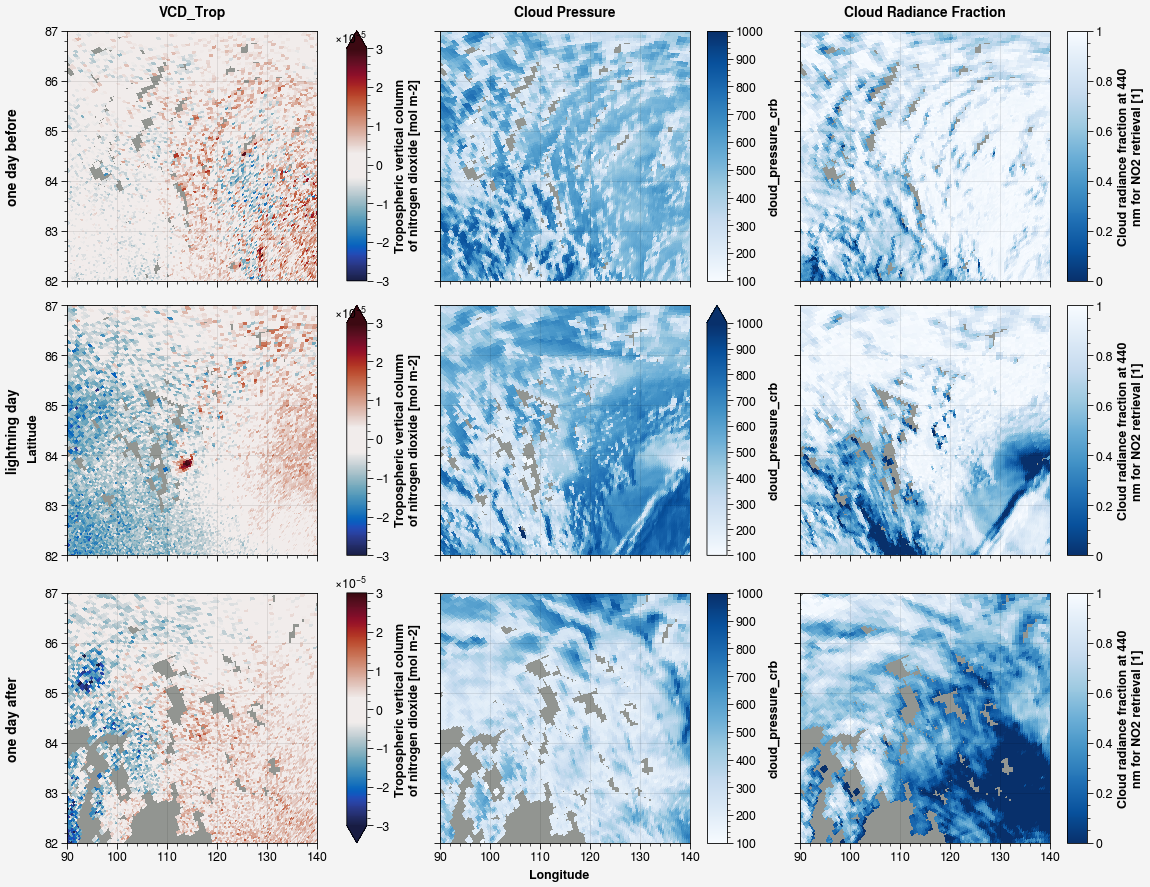

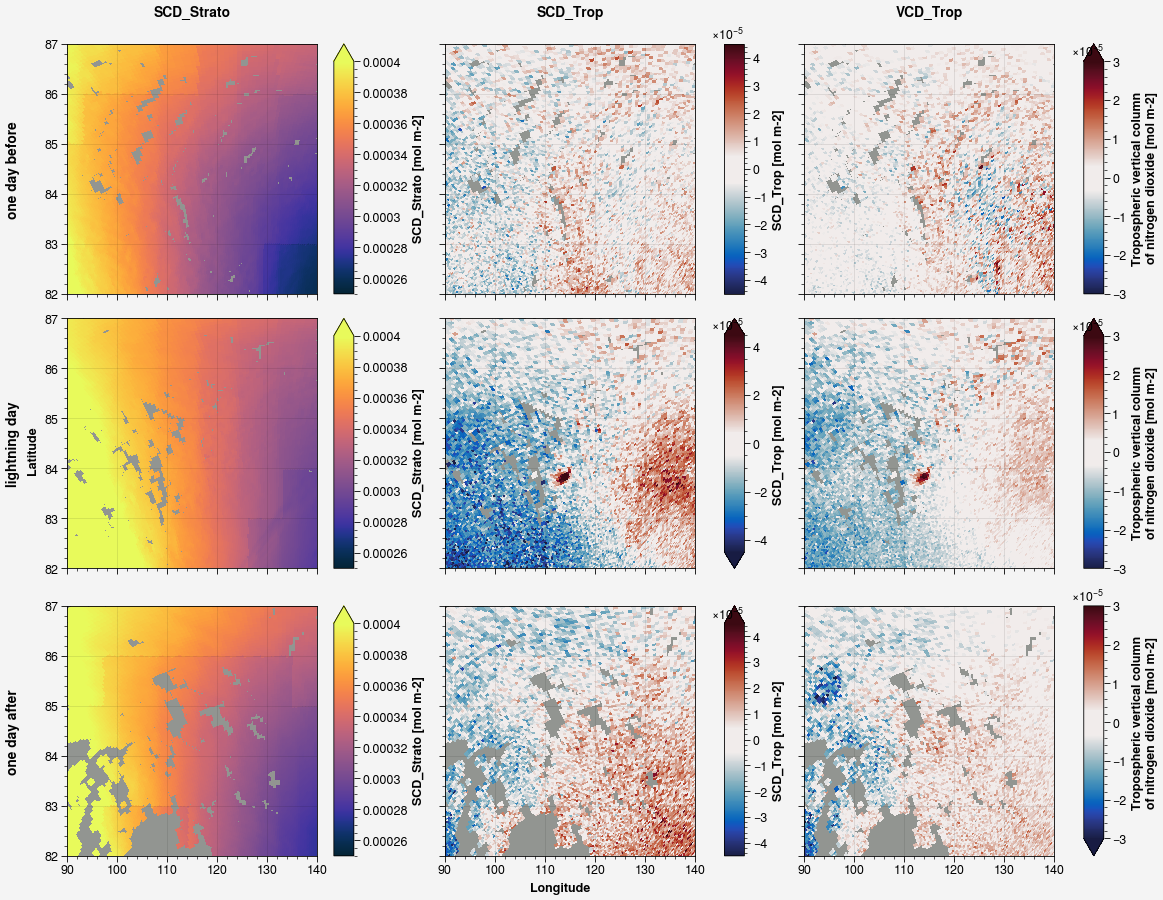

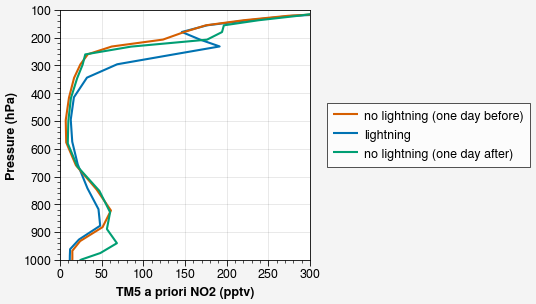

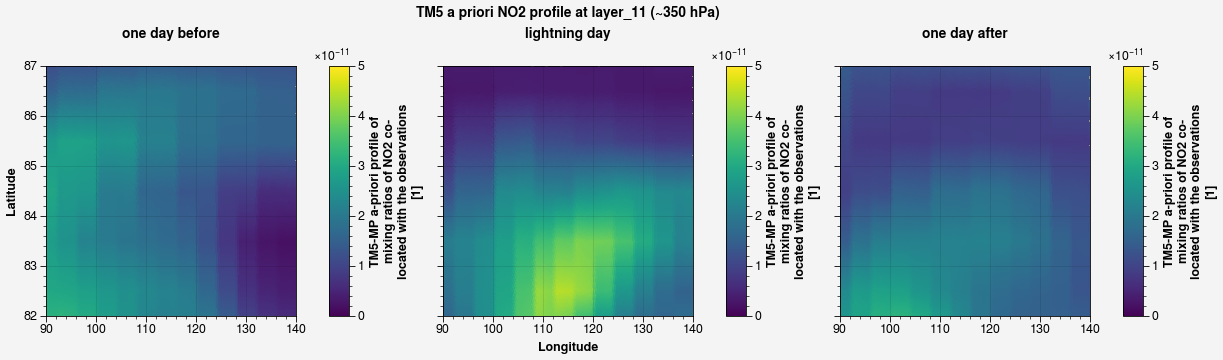

In [10]:
lon_min=90; lon_max=140; lat_min=82; lat_max=87

plot_cld([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min, lon_max, lat_min, lat_max)

plot_no2([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min, lon_max, lat_min, lat_max)

# Mean NO2 profile over the lightning NO2 region
plot_no2_profile([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min=113, lon_max=114, lat_min=83.8, lat_max=83.9)

# a priori NO2 at ~ 350 hPa
plot_no2_plev([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min=90, lon_max=140, lat_min=82, lat_max=87)

## Case 2: 2019-06-29

In [37]:
f_pre = glob('../data/tropomi/201906/S5P_PAL__L2__NO2____20190628T19*.nc')
f_ltng = glob('../data/tropomi/201906/S5P_PAL__L2__NO2____20190629T19*.nc')
f_post = glob('../data/tropomi/201906/S5P_PAL__L2__NO2____20190630T19*.nc')

scn_ltng_pre, scn_ltng, scn_ltng_post = get_scn(f_pre, f_ltng, f_post)

Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/cloud_selection_flag
Can't load ancillary dataset /PRODUCT/tm5_constant_a
Can't load ancillary dataset /PRODUCT/tm5_constant_b
Can't load ancillary dataset /PRODUCT/tm5_tropopause_layer_index
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/air_mass_factor_total
Can't load ancillary dataset /PRODUCT/averaging_kernel
Can't load ancillary dataset /PRODUCT/tm5_tropopause_layer_index
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/cloud_select

<xarray.DataArray 'nitrogendioxide_tropospheric_column' ()>
array(0.00026505, dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-06-29
    crs      object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs


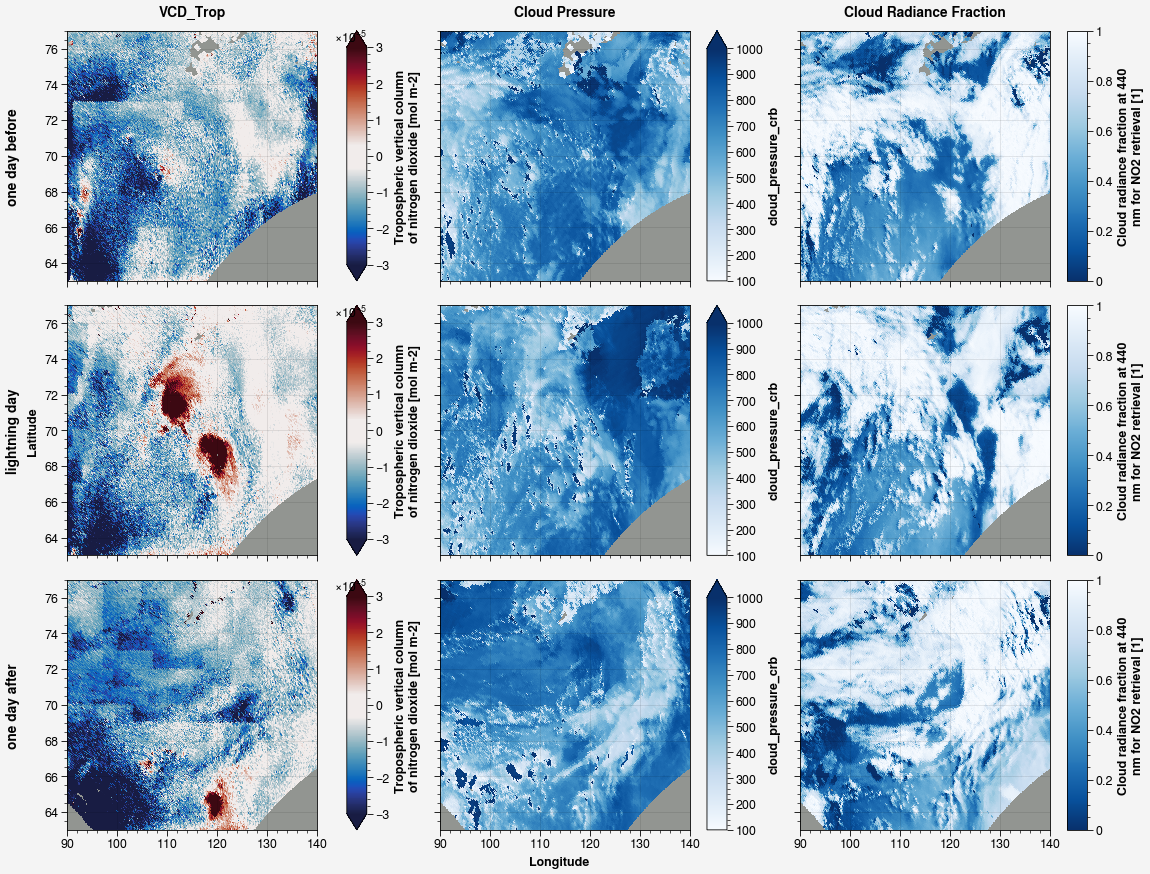

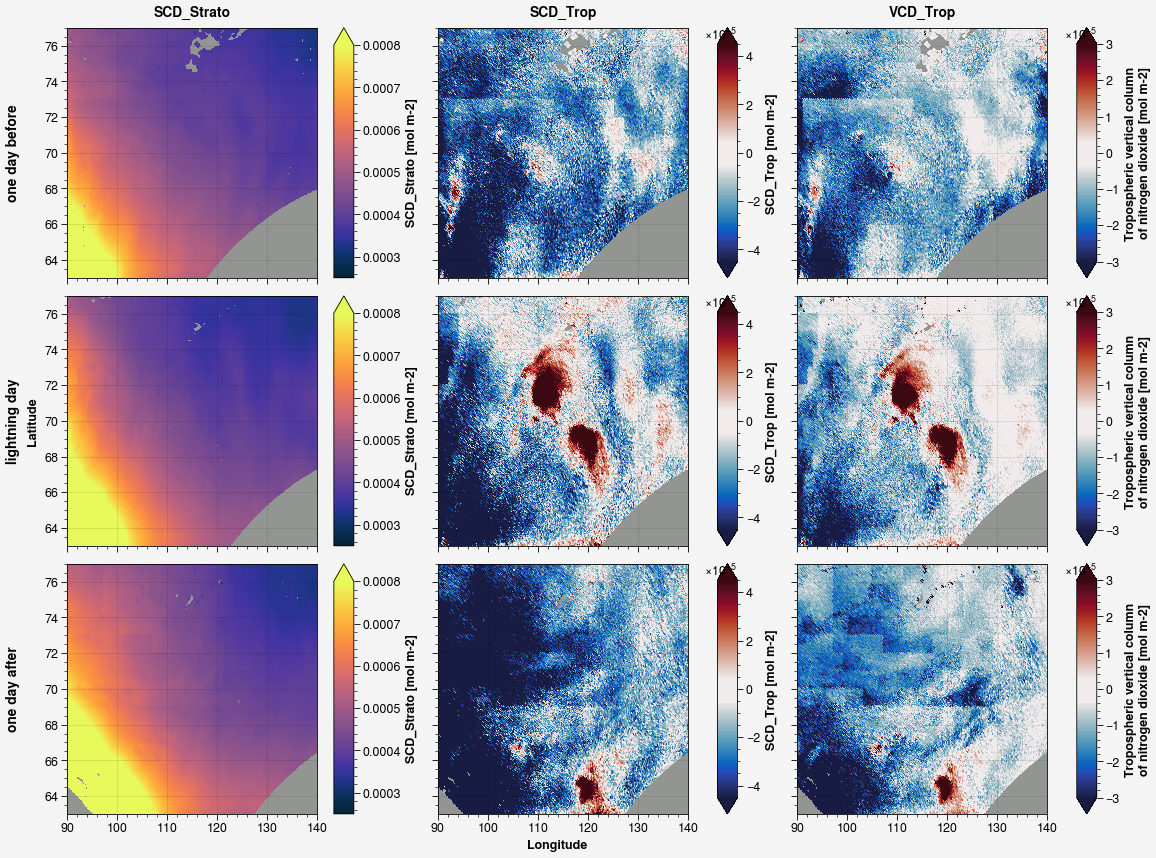

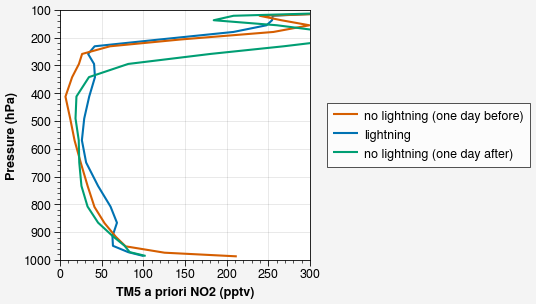

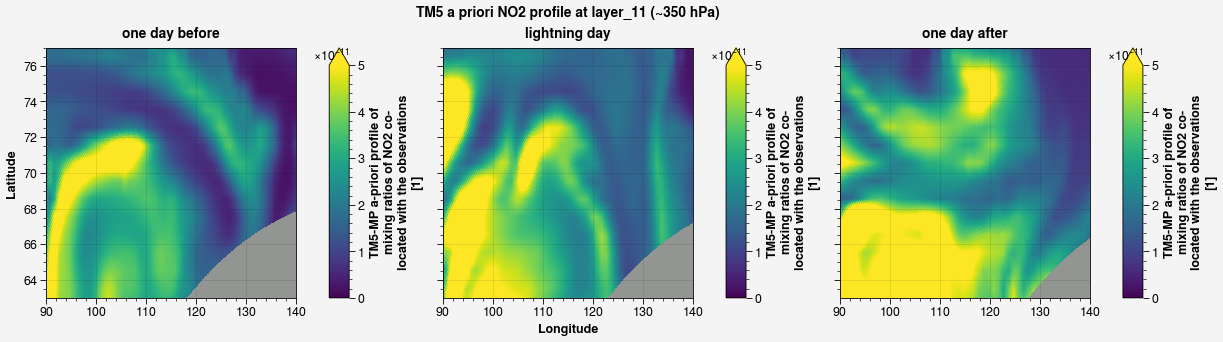

In [13]:
lon_min=90; lon_max=140; lat_min=63; lat_max=77

plot_cld([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min, lon_max, lat_min, lat_max)

plot_no2([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min, lon_max, lat_min, lat_max, vmax_strato=8e-4)

plot_no2_profile([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min=113, lon_max=114, lat_min=71, lat_max=72)

plot_no2_plev([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min, lon_max, lat_min, lat_max)

## Cloud slicing

Two methods of calculating the above-cloud NO2:

-  crf*(VCD_Trop-VCD_ghost) + (1−crf)*VCD_Trop (Boersma et al. 2005)
-  SCD_Trop/AMF_geo (Marais et al. 2021)

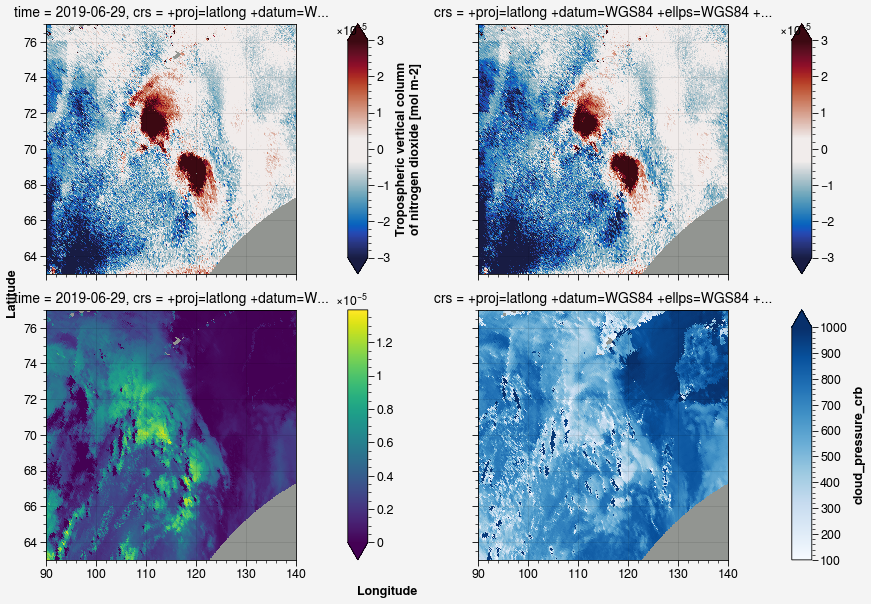

In [67]:
lon_min=90; lon_max=140; lat_min=63; lat_max=77

mask_slice = (scn_ltng['longitude'] >= lon_min) & \
    (scn_ltng['longitude'] <= lon_max) & \
    (scn_ltng['latitude'] >= lat_min) & \
    (scn_ltng['latitude'] <= lat_max)

fig, axs = pplt.subplots(nrows=2, ncols=2)

scn_ltng['nitrogendioxide_tropospheric_column'].where(mask_slice, drop=True).plot(
            x='longitude', y='latitude', ax=axs[0],
            cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-3e-5, vmax=3e-5,  discrete=False,
            )

no2_cld = scn_ltng['cloud_radiance_fraction_nitrogendioxide_window'] * (scn_ltng['nitrogendioxide_tropospheric_column']-scn_ltng['nitrogendioxide_ghost_column']) + (1-scn_ltng['cloud_radiance_fraction_nitrogendioxide_window'])*scn_ltng['nitrogendioxide_tropospheric_column']

amf_geo = 1/np.cos(np.radians(scn_ltng['solar_zenith_angle'])) + 1/np.cos(np.radians(scn_ltng['viewing_zenith_angle']))
no2_cld_geo = scn_ltng['SCD_Trop']/amf_geo

no2_cld.plot(x='longitude', y='latitude', ax=axs[1],
             cmap='Balance', cmap_kw={'cut': -0.1},
             vmin=-3e-5, vmax=3e-5,  discrete=False)

(scn_ltng['nitrogendioxide_tropospheric_column']-no2_cld).where(mask_slice, drop=True).plot(x='longitude', y='latitude', ax=axs[2],
             cmap='viridis', vmin=0, discrete=False)


(scn_ltng['cloud_pressure_crb']/1e2).where(mask_slice, drop=True).plot(
            x='longitude', y='latitude', ax=axs[3],
            cmap='Blues', vmin=100, vmax=1e3, discrete=False)


axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
            xlabel='Longitude', ylabel='Latitude',
            facecolor='Gray',
            )

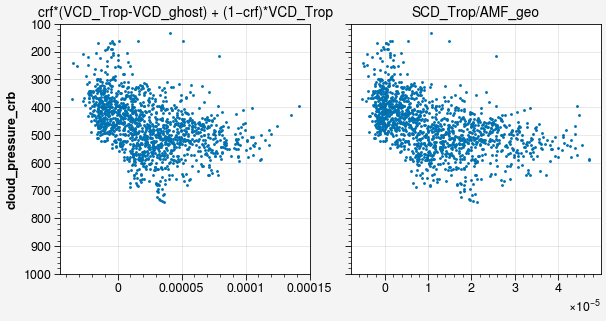

In [69]:
fig, axs = pplt.subplots(ncols=2)

lon_min=108; lon_max=114; lat_min=70; lat_max=72
mask_slice = (scn_ltng['longitude'] >= lon_min) & \
    (scn_ltng['longitude'] <= lon_max) & \
    (scn_ltng['latitude'] >= lat_min) & \
    (scn_ltng['latitude'] <= lat_max)


axs[0].scatter(no2_cld.where(mask_slice, drop=True).stack(z=['x', 'y']),
               scn_ltng['cloud_pressure_crb'].where(mask_slice, drop=True).stack(z=['x', 'y'])/1e2,
               s=2)
axs[0].format(title='crf*(VCD_Trop-VCD_ghost) + (1−crf)*VCD_Trop')

axs[1].scatter(no2_cld_geo.where(mask_slice, drop=True).stack(z=['x', 'y']),
               scn_ltng['cloud_pressure_crb'].where(mask_slice, drop=True).stack(z=['x', 'y'])/1e2,
               s=2)
axs[1].format(title='SCD_Trop/AMF_geo')

axs.format(ylim=(1000, 100))

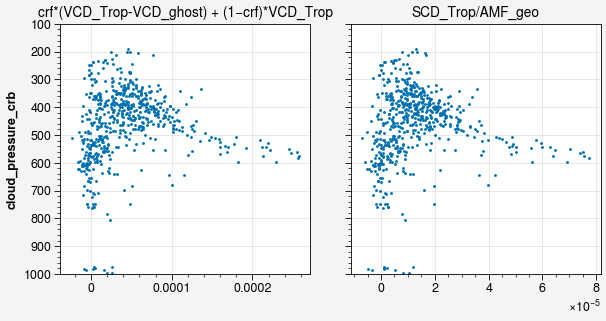

In [70]:
fig, axs = pplt.subplots(ncols=2)

lon_min=118; lon_max=122; lat_min=68; lat_max=70
mask_slice = (scn_ltng['longitude'] >= lon_min) & \
    (scn_ltng['longitude'] <= lon_max) & \
    (scn_ltng['latitude'] >= lat_min) & \
    (scn_ltng['latitude'] <= lat_max)


axs[0].scatter(no2_cld.where(mask_slice, drop=True).stack(z=['x', 'y']),
               scn_ltng['cloud_pressure_crb'].where(mask_slice, drop=True).stack(z=['x', 'y'])/1e2,
               s=2)
axs[0].format(title='crf*(VCD_Trop-VCD_ghost) + (1−crf)*VCD_Trop')

axs[1].scatter(no2_cld_geo.where(mask_slice, drop=True).stack(z=['x', 'y']),
               scn_ltng['cloud_pressure_crb'].where(mask_slice, drop=True).stack(z=['x', 'y'])/1e2,
               s=2)
axs[1].format(title='SCD_Trop/AMF_geo')

axs.format(ylim=(1000, 100))